## Processing Particle Trajectories

### We install some packages in order to analyze our trajectory data, fit to theoretical curves, and plot the corresponding quantities of interest 

In [3]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
from scipy.stats import norm, rayleigh
from scipy.optimize import curve_fit

### Our processed videos now have data stored in CSV files. We will call the CSV files in the current folder to conduct our analysis on. We set up a few lists to store the outputted velocities, MSD, and VACF of each trajectory. We trim each CSV so that the same amount of time of trajectory is analyzed. In this example, we choose to look at 30 seconds of video.

In [4]:
fps = 30                   # Frame rate (fps)
pixelconv = 833 / 100      # pixels per mm
# Each video is stopped by hand, so the videos are all slightly longer than 30 seconds. We take just the first 30 seconds to be consistent.
chunk_duration = 30  #in seconds      
#Number                            
chunk_size = int(chunk_duration * fps)  # frames to analyze per file

#We will now call of the csv files that were previously tracked.
csv_files = glob.glob('*_tracked.csv')
print(f"Found {len(csv_files)} CSV files to process.")

vs_all = []
speeds_all = []

Found 1 CSV files to process.


In [5]:
for filename in csv_files:
    data = pd.read_csv(filename)
    #If you accidently took a video less than video minimum length size, it will be omitted.
    if len(data) < chunk_size:
        print(f"Skipping {filename}: only {len(data)} frames, need at least {chunk_size}")
        continue
        
    #The trajectory in pixels is converted to mm using the unit conversion
    trajectory = data[['x', 'y']].values[:chunk_size] / pixelconv
    
    dts = 1 / fps
    vs = (trajectory[2:] - trajectory[:-2]) / (2 * dts)
    
    speeds = np.linalg.norm(vs, axis=1)
    
    vs_all.append(vs)
    speeds_all.append(speeds)

In [8]:
all_vx = np.hstack([vs[:, 0] for vs in vs_all])
all_vy = np.hstack([vs[:, 1] for vs in vs_all])
all_speeds = np.hstack(speeds_all)

mu_vx, std_vx = norm.fit(all_vx)
mu_vy, std_vy = norm.fit(all_vy)

speeds_fit = all_speeds[all_speeds > 0]
params_rayleigh = rayleigh.fit(speeds_fit, floc=0)
scale_rayleigh = params_rayleigh[1]

mean_speed = np.nanmean(all_speeds)
print( f"The mean speed of the particle is {mean_speed.round(2)} mm/s")

The mean speed of the particle is 3.11 mm/s


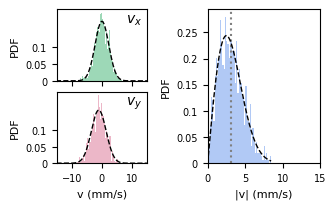

In [9]:
# --- Plot velocity histograms ---
nedge = 50
width_inches = 3.4
height_inches = 2.0

fig = plt.figure(figsize=(width_inches, height_inches))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.8, 1], height_ratios=[1, 1], wspace=0.6, hspace=0.15)

ax0 = fig.add_subplot(gs[0, 0])
ax0.hist(all_vx, bins=nedge, density=True, alpha=0.5, color='mediumseagreen', edgecolor='none')
ax0.set_xlim([-15, 15])
ax0.set_ylabel('PDF', fontsize=8)
ax0.set_yticks([0, .05, 0.1])
ax0.set_xticks(np.linspace(-10, 10, 3))
ax0.set_xticklabels([])
ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2g'))
ax0.tick_params(axis='both', labelsize=7)
x_vx = np.linspace(-30, 30, 200)
ax0.plot(x_vx, norm.pdf(x_vx, mu_vx, std_vx), 'k--', linewidth=1)

ax0.text(
    0.95, 0.95,         
    r'$v_x$',       
    transform=ax0.transAxes,  
    fontsize=10,   
    verticalalignment='top',
    horizontalalignment='right',
    color='black' 
)

ax1 = fig.add_subplot(gs[1, 0])
ax1.hist(all_vy, bins=nedge, density=True, alpha=0.5, color='palevioletred', edgecolor='none')
ax1.set_xlim([-15, 15])
ax1.set_xlabel('v (mm/s)', fontsize=8)
ax1.set_ylabel('PDF', fontsize=8)
ax1.set_yticks([0, .05, 0.1])
ax1.set_xticks(np.linspace(-10, 10, 3))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2g'))
ax1.tick_params(axis='both', labelsize=7)
x_vy = np.linspace(-20, 20, 200)
ax1.plot(x_vy, norm.pdf(x_vy, mu_vy, std_vy), 'k--', linewidth=1)

ax1.text(
    0.95, -0.2,       
    r'$v_y$',           
    transform=ax0.transAxes, 
    fontsize=10,         
    verticalalignment='top',  
    horizontalalignment='right', 
    color='black'        
)

ax2 = fig.add_subplot(gs[:, 1])
ax2.hist(all_speeds, bins=nedge, density=True, alpha=0.5, color='cornflowerblue', edgecolor='none')
ax2.axvline(mean_speed, color='gray', linestyle=':', linewidth=1.5)
ax2.set_xlabel('|v| (mm/s)', fontsize=8)
ax2.set_ylabel('PDF', fontsize=8)
x_speed = np.linspace(0, speeds_fit.max(), 200)
ax2.plot(x_speed, rayleigh.pdf(x_speed, loc=0, scale=scale_rayleigh), linestyle = '--',color = 'k', linewidth=1)
ax2.set_xticks([0, 5, 10, 15])
ax2.set_xlim([0, 15])
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2g'))
ax2.tick_params(axis='both', labelsize=7)

plt.savefig('velocity_speed_histograms.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()